# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import xgboost as xgb
from catboost import CatBoostRegressor

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)

sns.set_style("white")
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = [16.0, 10.0]

In [2]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]
seed=111
p = 0.1
bc_dataframe = []
for date in dates:
    df = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    bc_dataframe.append(df)
bc_dataframe = pd.concat(bc_dataframe, axis=0)

In [244]:
bc_dataframe

,periodo,id_cli,edad,genero,estado_civil,ult_actual,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,...,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,201902,8584182,68,M,CAS,20181112,N,BOGOTA D.C.,Entre 0 y 30 dias,0.00000,...,1921000.00000,44551000.00000,0.00000,3,375066.18500,B,S,0.00000,0.00000,1198992.00000
1,201902,309996,46,F,CAS,20190104,N,ANTIOQUIA,Entre 0 y 30 dias,0.00000,...,226000.00000,79861000.00000,0.00000,4,8050836.86250,F,N,0.00000,0.00000,1097495.00000
2,201902,2936047,42,M,CAS,20180810,N,ANTIOQUIA,Entre 0 y 30 dias,0.00000,...,0.00000,0.00000,0.00000,0,5213508.40500,NApl,N,0.00000,0.00000,0.00000
3,201902,3904495,38,F,SOL,20180707,N,ANTIOQUIA,NApl,0.00000,...,0.00000,5346000.00000,0.00000,0,-4780750.00000,H,N,0.00000,0.00000,385939.00000
4,201902,2585668,26,F,SOL,20180526,N,ATLANTICO,Entre 0 y 30 dias,4700000.00000,...,0.00000,0.00000,0.00000,1,1717007.00000,C,N,0.00000,0.00000,99922.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110767,202011,4699764,27,M,SOL,20190404,N,ANTIOQUIA,Entre 0 y 30 dias,2000000.00000,...,0.00000,13511000.00000,0.00000,2,-225525.00000,A,N,0.00000,1956240.00000,3525617.99000
110768,202011,616871,48,M,SOL,20200218,N,TOLIMA,Entre 0 y 30 dias,8800000.00000,...,0.00000,0.00000,0.00000,6,197543.80000,C,N,1854243.50000,0.00000,122040.00000
110769,202011,2863977,34,M,NI,20180526,N,VALLE,Mas de 60,0.00000,...,235000.00000,24870000.00000,16314000.00000,7,-34644450.00000,G,N,0.00000,2780000.00000,433419.00000
110770,202011,4763067,37,M,SOL,20200902,N,BOGOTA D.C.,Entre 0 y 30 dias,23400000.00000,...,1142000.00000,203000.00000,0.00000,3,35616749.06250,C,N,0.00000,828116.00000,0.00000


In [13]:
bc_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210123 entries, 0 to 11011
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   periodo                        210123 non-null  int64  
 1   id_cli                         210123 non-null  int64  
 2   edad                           210123 non-null  int64  
 3   genero                         210123 non-null  object 
 4   estado_civil                   210123 non-null  object 
 5   ult_actual                     210123 non-null  int64  
 6   ind_mora_vigente               210123 non-null  object 
 7   departamento_residencia        210123 non-null  object 
 8   mora_max                       210123 non-null  object 
 9   cupo_total_tc                  210123 non-null  float64
 10  cuota_tc_bancolombia           210123 non-null  float64
 11  nro_tot_cuentas                210123 non-null  int64  
 12  ctas_activas                   

<AxesSubplot:>

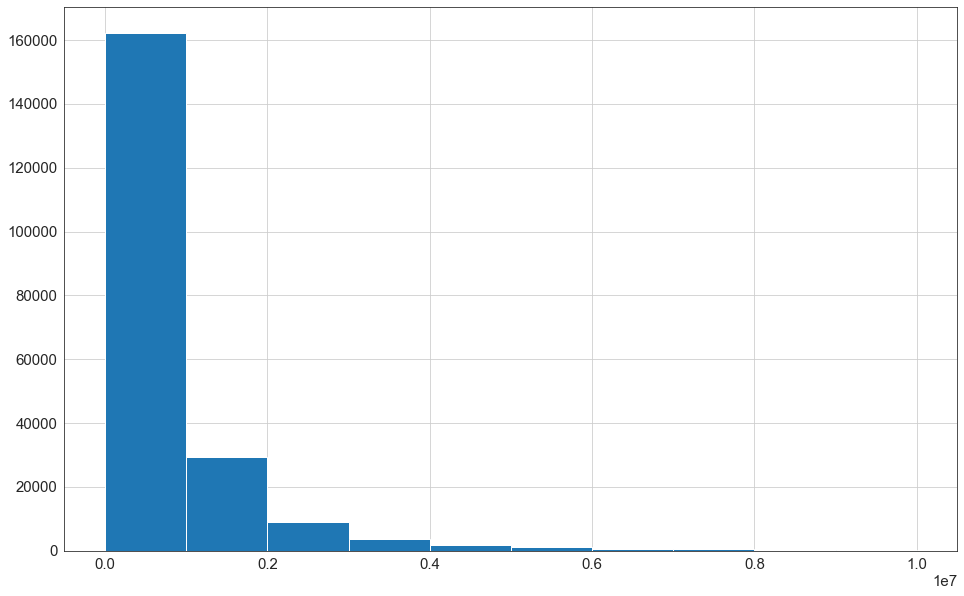

In [5]:
bc_dataframe[(bc_dataframe['gasto_familiar'] < 10000000) &
             (bc_dataframe['gasto_familiar'] >= 0)]['gasto_familiar'].hist()

<AxesSubplot:>

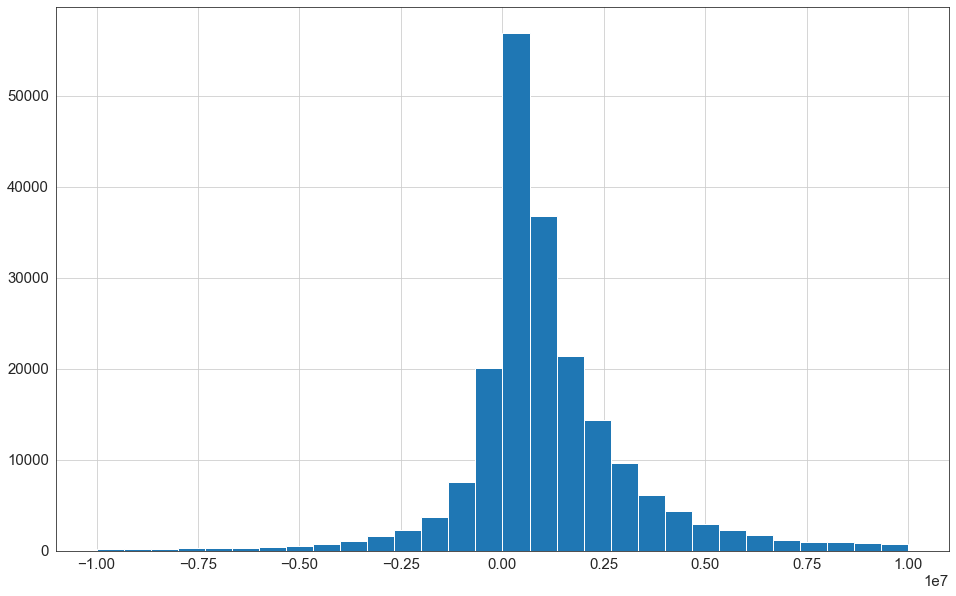

In [40]:
bc_dataframe[(bc_dataframe['ind'] >=-10000000) &
            (bc_dataframe['ind'] < 10000000)]['ind'].hist(bins=30)

<AxesSubplot:>

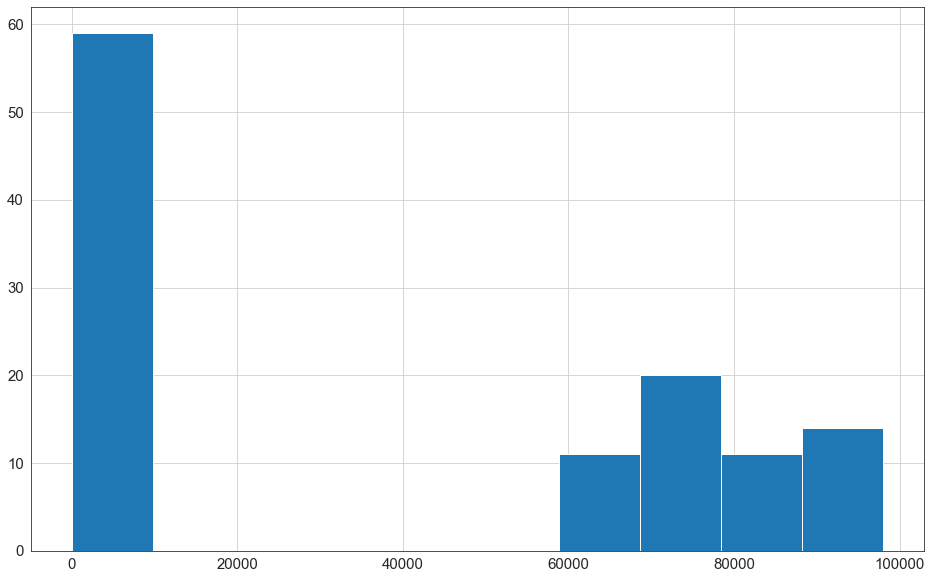

In [49]:
bc_dataframe[(bc_dataframe['ingreso_final'] < 100000)]['ingreso_final'].hist()

In [90]:
pct_spending=len(bc_dataframe[(bc_dataframe['gasto_familiar'] < 10000000) &
             (bc_dataframe['gasto_familiar'] >= 0)]['gasto_familiar']) / len(bc_dataframe)
print(f"Porcentaje de personas con gastos familiares entre 0 y 10 millones: {pct_spending}")

Porcentaje de personas con gastos familiares entre 0 y 10 millones: 0.9955978165169924


<AxesSubplot:>

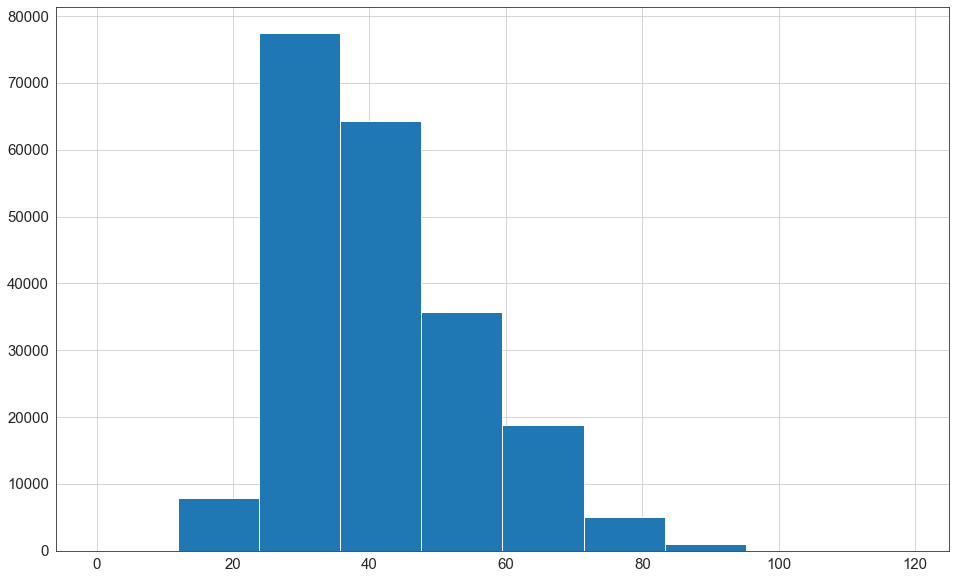

In [7]:
bc_dataframe['edad'].hist()

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='edad', ylabel='gasto_familiar'>

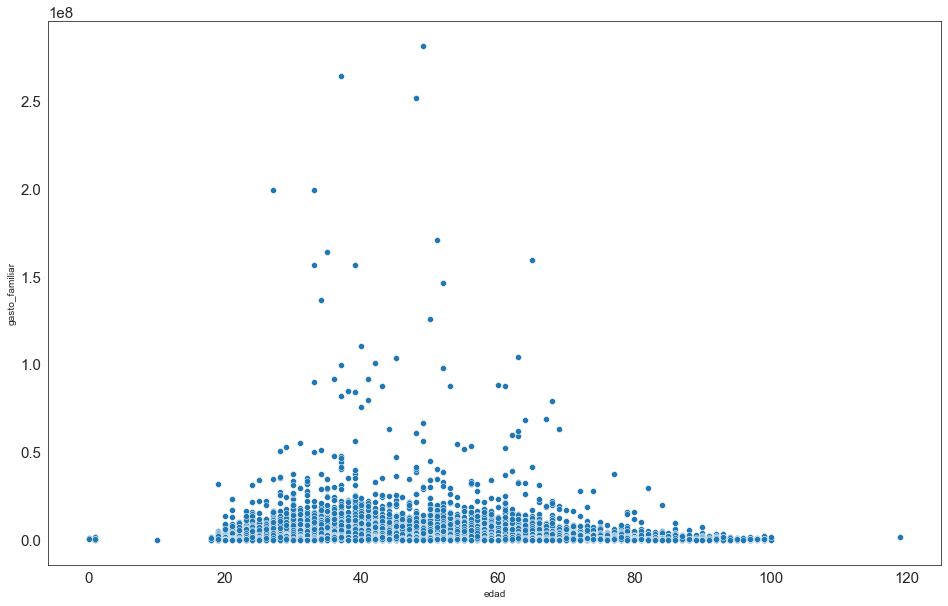

In [8]:
sns.scatterplot(bc_dataframe['edad'], bc_dataframe['gasto_familiar'])

<AxesSubplot:xlabel='genero'>

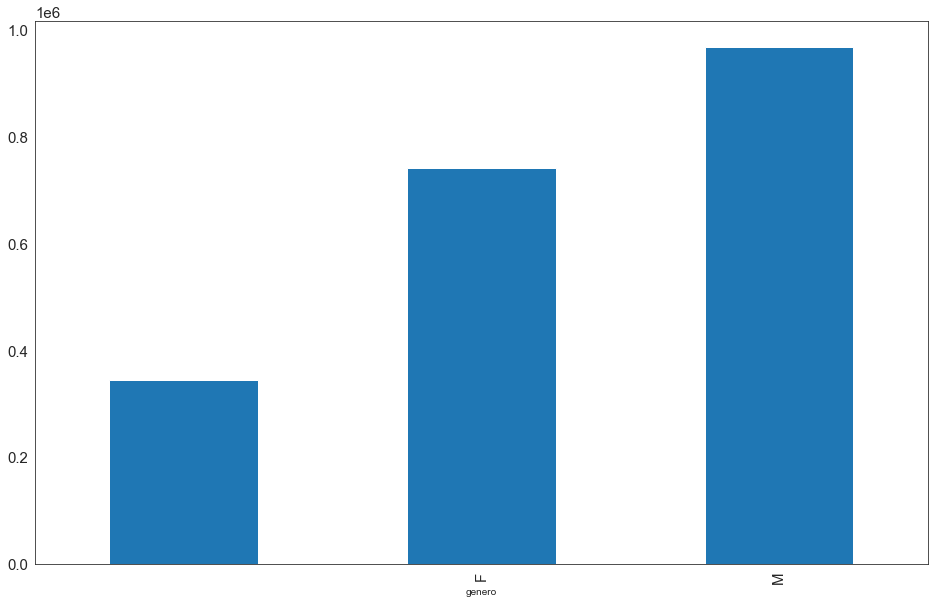

In [17]:
bc_dataframe.groupby('genero')['gasto_familiar'].mean().plot(kind='bar')

In [22]:
bc_dataframe[bc_dataframe['gasto_familiar'] < 0]

,periodo,id_cli,edad,genero,estado_civil,ult_actual,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,...,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar


<AxesSubplot:>

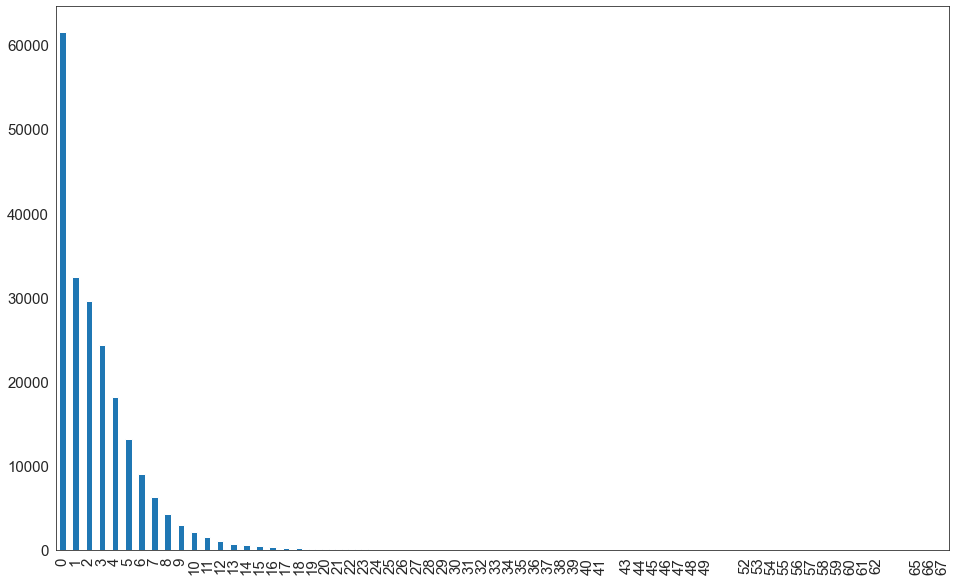

In [32]:
bc_dataframe['cant_oblig_tot_sf'].value_counts().plot(kind='bar')

In [53]:
bc_dataframe[bc_dataframe['gasto_familiar'] == 0]

,periodo,id_cli,edad,genero,estado_civil,ult_actual,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,...,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
3,201902,3905021,28,F,SOL,20180824,N,BOGOTA D.C.,Entre 0 y 30 dias,0.0,...,2333000.0,17821000.0,0.0,5,-2.011812e+05,D,N,1840000.0,0.0,0.0
22,201902,2114397,44,F,SOL,20180906,N,CUNDINAMARCA,NApl,0.0,...,0.0,64124000.0,0.0,1,5.457897e+05,B,N,0.0,0.0,0.0
31,201902,8132417,58,M,CAS,20180823,N,CORDOBA,Entre 0 y 30 dias,7300000.0,...,237000.0,1721000.0,0.0,6,1.435327e+04,C,N,0.0,0.0,0.0
45,201902,8167939,69,F,NI,20180817,N,BOGOTA D.C.,Entre 0 y 30 dias,0.0,...,0.0,131769000.0,0.0,1,-5.671765e+05,H,N,0.0,0.0,0.0
51,201902,966757,38,F,SOL,20181023,N,ESTADO EXTERIOR,NApl,0.0,...,0.0,0.0,0.0,0,1.147500e+05,NApl,N,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10936,202011,1503360,38,F,SOL,20200803,S,VALLE,Entre 0 y 30 dias,0.0,...,0.0,46000.0,0.0,2,-6.752020e+05,G,N,1719000.0,1200000.0,0.0
10945,202011,164784,46,F,NI,20190117,N,BOGOTA D.C.,NApl,0.0,...,16000.0,3517000.0,0.0,2,3.998452e+05,H,S,1047036.0,1331000.0,0.0
10970,202011,2085434,39,F,UL,20190722,N,BOLIVAR,Entre 0 y 30 dias,0.0,...,470000.0,96120000.0,0.0,7,-4.103800e+05,D,N,0.0,828116.0,0.0
10985,202011,909574,40,M,CAS,20200617,N,ATLANTICO,NApl,0.0,...,0.0,0.0,0.0,0,2.439291e+06,C,N,0.0,4099648.0,0.0


In [63]:
bc_dataframe['ingreso_calculado'] =  bc_dataframe['ingreso_segurida_social']  + bc_dataframe['ingreso_nompen'] 

In [66]:
bc_dataframe[['ingreso_calculado', 'ingreso_final']]

,ingreso_calculado,ingreso_final
0,2632226.0,2.827421e+06
1,0.0,1.701541e+06
2,0.0,1.052586e+07
3,1840000.0,2.745875e+06
4,0.0,4.865000e+06
...,...,...
11007,2462702.0,3.213373e+06
11008,1500000.0,5.353454e+06
11009,0.0,1.577280e+06
11010,1069390.0,1.069390e+06


g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ingreso_final', ylabel='ingreso_calculado'>

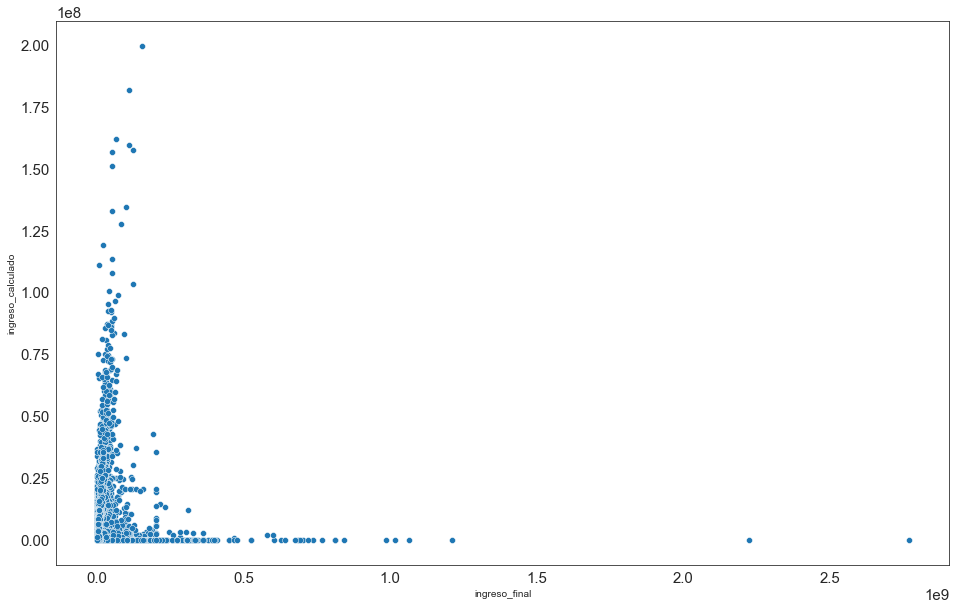

In [64]:
bc_dataframe[['ingreso_nompen', 'ingreso_nomina']]
sns.scatterplot(bc_dataframe['ingreso_final'], bc_dataframe['ingreso_calculado'])

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='gasto_familiar'>

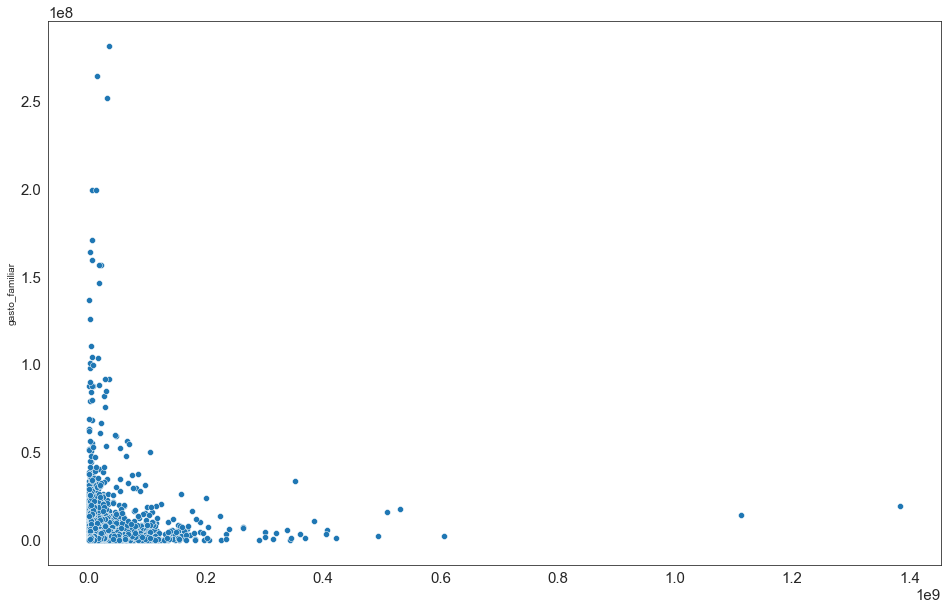

In [69]:
sns.scatterplot((bc_dataframe['ingreso_calculado'] + bc_dataframe['ingreso_final'])/2, bc_dataframe['gasto_familiar'])

In [62]:
bc_dataframe[bc_dataframe['cat_ingreso'] == "NOM"][['cat_ingreso','ingreso_nompen', 'ingreso_nomina']]

,cat_ingreso,ingreso_nompen,ingreso_nomina
0,NOM,2632226.0,2009941.5
3,NOM,1840000.0,1840000.0
7,NOM,18057540.0,5547700.0
8,NOM,2826718.0,3113016.0
12,NOM,2744866.0,2746783.0
...,...,...,...
11000,NOM,3076221.0,3151361.0
11002,NOM,5921587.0,0.0
11005,NOM,1428000.0,0.0
11007,NOM,2462702.0,2227125.0


In [60]:
bc_dataframe['cat_ingreso'].value_counts()

OTROS      126998
NOM         70901
PEN         11521
NOM PEN       703
Name: cat_ingreso, dtype: int64

# Preprocessing class

In [4]:
class DataFramePreProcessor:
    
    def __init__(self, dataframe, test=False):
        self.test = test
        self.original_dataframe = dataframe.copy()
        self.modeling_dataframe = None
    
    
    def handleMissingData(self, dataframe):
        dataframe['ingreso_final'] = dataframe['ingreso_final'].fillna(0)
        dataframe['ind'] = dataframe['ind'].fillna(0)
        return dataframe
    
    # Borrar filas deacuerdo a cierta logica de negocio
    def rowFilter(self, dataframe):
        return dataframe[
            (dataframe['edad'] < 80) & # Imputar a percentil 99
            (dataframe['gasto_familiar'] >= 0) &
            (dataframe['gasto_familiar'] < 10000000) &
            (dataframe['cant_oblig_tot_sf'] < 13) &
            (dataframe['cuota_de_consumo'] >= 0) & # Mas bien transformar a cero
            (dataframe['ingreso_final'] < 50000000) &
            (dataframe['cuota_cred_hipot'] > 0)
        ] 
    
    def oneEncodeVariables(self):
        pass
    
    def newVars(self, dataframe):
        pct_vars = [
            'cuota_cred_hipot',
            'cuota_tarjeta_de_credito',
            'cuota_de_consumo',
            'cuota_rotativos',
            'cuota_sector_real_comercio',
            'cuota_de_sector_solidario',
            'cuota_tc_bancolombia',
            'cuota_libranza_sf',
            'cupo_total_tc',
            'cupo_tc_mdo'
        ]
        
        cat_vars = [
            'mora_max', # Tal vez haya que encontrar el umbral correcto
            'estado_civil',
            'rep_calif_cred'
        ]
        

        
        dummified = []
        for var in cat_vars:
            dummified.append(
                pd.get_dummies(dataframe[var], drop_first=True, prefix=var)
            )
        
        dummified = pd.concat(dummified, axis=1)
        dataframe = pd.concat([dataframe.drop(cat_vars, axis=1),dummified], axis=1)
        for var in pct_vars:
            dataframe[f"{var}_pct"] = dataframe[var] / dataframe['ingreso_final'] 
            dataframe[f"{var}_pct"] = dataframe[f"{var}_pct"].replace(dict.fromkeys([np.nan, np.inf], 0))
            
        for var in pct_vars:
            dataframe[f"{var}_log"] = np.log(dataframe[var]+1)
        
        dataframe['genero'] = np.where(dataframe['genero'] == 'M', 0, 1)
        dataframe['ind_mora_vigente'] = np.where(dataframe['ind_mora_vigente'] == "S", 1, 0)
        dataframe['convenio_lib'] = np.where(dataframe['convenio_lib'] == 'S', 1, 0)
        dataframe['ingreso_calculado'] =  dataframe['ingreso_segurida_social']  +  \
                                          dataframe[['ingreso_nompen', 'ingreso_nomina']].max(axis=1) 
        dataframe['ind_annio'] = dataframe['periodo'].apply(lambda x: 1 if str(x)[:4] == '2020' else 0)
        dataframe['ind_covid'] = np.where(
            dataframe['periodo'].isin([202004,202003,202005]), 1,0)
        if not self.test:
            dataframe['log_gasto_familiar'] = np.log(dataframe['gasto_familiar'] +1 ) 
            
        dataframe['ingreso_final'] = np.log(dataframe['ingreso_final']+1)
        dataframe['cupo_total_tc'] = np.log(dataframe['cupo_total_tc']+1)
        dataframe['ingreso_nomina'] = np.log(dataframe['ingreso_nomina']+1)
        dataframe['ingreso_segurida_social'] = np.log(dataframe['ingreso_segurida_social']+1)
        dataframe['ingreso_nompen'] = np.log(dataframe['ingreso_nompen']+1)
        dataframe['ingreso_calculado'] = np.log(dataframe['ingreso_calculado']+1)
        
         

        dataframe['obl_total_pct'] = dataframe['cuota_cred_hipot_pct'] + \
                                     dataframe['cuota_tarjeta_de_credito_pct'] +\
                                     dataframe['cuota_de_consumo_pct'] + \
                                     dataframe['cuota_rotativos_pct'] + \
                                     dataframe['cuota_sector_real_comercio_pct'] + \
                                     dataframe['cuota_de_sector_solidario_pct'] + \
                                     dataframe['cuota_libranza_sf_pct']
                                
        dataframe['ingreso_corr'] = dataframe[['ingreso_final', 'ingreso_calculado']].max(axis=1)
        dataframe['ingreso_corr_log'] = np.log(dataframe['ingreso_corr']+1)
        
        dataframe['interact_ing_gen']  = dataframe['genero'] * dataframe['ingreso_corr']
        dataframe['interact_ing_ed']  = dataframe['edad'] * dataframe['ingreso_corr']
        dataframe['interact_cup_gen']  = dataframe['genero'] * dataframe['cupo_total_tc']
        dataframe['interact_cup_ed']  = dataframe['edad'] * dataframe['cupo_total_tc']
        
        dataframe['ingreso_cero'] = np.where(dataframe['ingreso_corr'] == 0, 1, 0)
        dataframe['ingreso_geo_alto']  = np.where(dataframe['ingreso_corr'] < 14.90, 1, 0) # ALgo mas tecnico
        dataframe['es_ciudad_principal'] = np.where(
            dataframe['departamento_residencia'].isin(['BOGOTA D.C.', 'ANTIOQUIA', 'VALLE', 'CUNDINAMARCA']), 1,0)
        
        dataframe['pc10'] = np.where(dataframe['ingreso_corr'] <= np.quantile(dataframe['ingreso_corr'],0.1), 1, 0)
        dataframe['pc90'] = np.where(dataframe['ingreso_corr'] >= np.quantile(dataframe['ingreso_corr'],0.9), 1, 0)

        return dataframe
    
    def process(self):
        
        complete_df = self.handleMissingData(self.original_dataframe)
        if not self.test:
            filtered_df = self.rowFilter(complete_df)
            grown_df    = self.newVars(filtered_df)
        else:
            grown_df    = self.newVars(complete_df)
        self.modeling_dataframe = grown_df
        
        return self.modeling_dataframe
        

In [206]:
fe_dataframe.modeling_dataframe[fe_dataframe.modeling_dataframe['cuota_libranza_sf'] < 0 ]

,periodo,id_cli,edad,genero,ult_actual,ind_mora_vigente,departamento_residencia,cupo_total_tc,cuota_tc_bancolombia,nro_tot_cuentas,...,ingreso_corr,interact_ing_gen,interact_ing_ed,interact_cup_gen,interact_cup_ed,ingreso_cero,ingreso_geo_alto,es_ciudad_principal,pc10,pc90


In [207]:
fe_dataframe.modeling_dataframe['cuota_cred_hipot'].describe()

count     122491.00000
mean      807668.67164
std       749693.33845
min          651.37500
25%       342860.82000
50%       595544.59000
75%      1021982.54500
max     17369144.46000
Name: cuota_cred_hipot, dtype: float64

In [305]:
fe_dataframe.modeling_dataframe.groupby('es_ciudad_principal')['gasto_familiar'].mean()

es_ciudad_principal
0   1211598.09147
1   1289140.64473
Name: gasto_familiar, dtype: float64

In [5]:
fe_dataframe = DataFramePreProcessor(bc_dataframe)

In [6]:
fe_dataframe.process()

,periodo,id_cli,edad,genero,ult_actual,ind_mora_vigente,departamento_residencia,cupo_total_tc,cuota_tc_bancolombia,nro_tot_cuentas,...,ingreso_corr_log,interact_ing_gen,interact_ing_ed,interact_cup_gen,interact_cup_ed,ingreso_cero,ingreso_geo_alto,es_ciudad_principal,pc10,pc90
13,201902,3529380,35,1,20181227,0,ANTIOQUIA,0.00000,0.00000,1,...,2.79958,15.43782,540.32370,0.00000,0.00000,0,0,1,0,0
17,201902,1588624,38,0,20170814,0,BOGOTA D.C.,0.00000,0.00000,0,...,2.75315,0.00000,558.29470,0.00000,0.00000,0,1,1,0,0
97,201902,2131147,29,1,20181001,1,VALLE,0.00000,0.00000,1,...,2.80502,15.52736,450.29331,0.00000,0.00000,0,0,1,0,0
102,201902,2264031,33,1,20171117,0,BOGOTA D.C.,16.03471,450800.00000,2,...,2.85028,16.29259,537.65538,16.03471,529.14557,0,0,1,0,0
118,201902,1274806,50,1,20180525,0,BOGOTA D.C.,0.00000,0.00000,1,...,2.72683,14.28443,714.22149,0.00000,0.00000,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110133,202011,3413099,48,0,20180528,0,ANTIOQUIA,0.00000,0.00000,1,...,2.71349,0.00000,675.92770,0.00000,0.00000,0,1,1,0,0
110179,202011,4962097,54,0,20200825,0,ANTIOQUIA,0.00000,0.00000,1,...,2.74989,0.00000,790.61157,0.00000,0.00000,0,1,1,0,0
110187,202011,190045,47,1,20180807,1,RISARALDA,13.99783,39495.07350,0,...,2.74241,14.52440,682.64702,13.99783,657.89815,0,1,0,0,0
110193,202011,2045927,48,0,20200909,0,CAUCA,0.00000,0.00000,1,...,2.78030,0.00000,725.94450,0.00000,0.00000,0,0,0,0,0


In [52]:
np.quantile(bc_dataframe.dropna()['ingreso_final'], 0.9)

9311748.6

In [395]:
fe_dataframe.modeling_dataframe[['ingreso_final', 'ingreso_calculado', 'ingreso_corr']].corr()

,ingreso_final,ingreso_calculado,ingreso_corr
ingreso_final,1.00000,0.01813,0.87505
ingreso_calculado,0.01813,1.00000,0.14357
ingreso_corr,0.87505,0.14357,1.00000


# Modeling

In [76]:
fe_dataframe.modeling_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1617483 entries, 0 to 88159
Data columns (total 83 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   periodo                         1617483 non-null  int64  
 1   id_cli                          1617483 non-null  int64  
 2   edad                            1617483 non-null  int64  
 3   genero                          1617483 non-null  int32  
 4   ult_actual                      1617483 non-null  int64  
 5   ind_mora_vigente                1617483 non-null  int32  
 6   departamento_residencia         1617483 non-null  object 
 7   cupo_total_tc                   1617483 non-null  float64
 8   cuota_tc_bancolombia            1617483 non-null  float64
 9   nro_tot_cuentas                 1617483 non-null  int64  
 10  ctas_activas                    1617483 non-null  int64  
 11  cuota_cred_hipot                1617483 non-null  float64
 12  me

In [33]:
feature_cols = [
     'ingreso_corr_log',
  #  'ingreso_final',
  #  'ingreso_calculado',
    'cuota_cred_hipot_log',
    'cuota_tarjeta_de_credito_log',
    'cuota_de_consumo_log',
    'cuota_rotativos_log',
    'cuota_libranza_sf_log',
   # 'genero',
    'cuota_de_sector_solidario',
    'cuota_sector_real_comercio',
    'ind_mora_vigente',
    'ind_annio',
    'cuota_tc_bancolombia_log',
    'cupo_tc_mdo_log',
    'convenio_lib',
    'cant_oblig_tot_sf',
    'edad',
    #'estado_civil_DIV',
    #'estado_civil_NI',
    #'estado_civil_OTRO',
    'estado_civil_SOL',
    #'estado_civil_UL',
    #'estado_civil_VIU',
    'nro_tot_cuentas',
    'ctas_activas',
    'interact_ing_gen',
    'interact_ing_ed',
    'interact_cup_gen',
    'interact_cup_ed',
    'obl_total_pct',
    'ingreso_cero',
    'ingreso_geo_alto',
    'es_ciudad_principal',
    'cupo_total_tc_log',
    'ind_covid'
]
X = fe_dataframe.modeling_dataframe[fe_dataframe.modeling_dataframe['periodo'] == 202007][feature_cols]
y = fe_dataframe.modeling_dataframe[fe_dataframe.modeling_dataframe['periodo'] == 202007]['gasto_familiar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [34]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=101)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=101,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

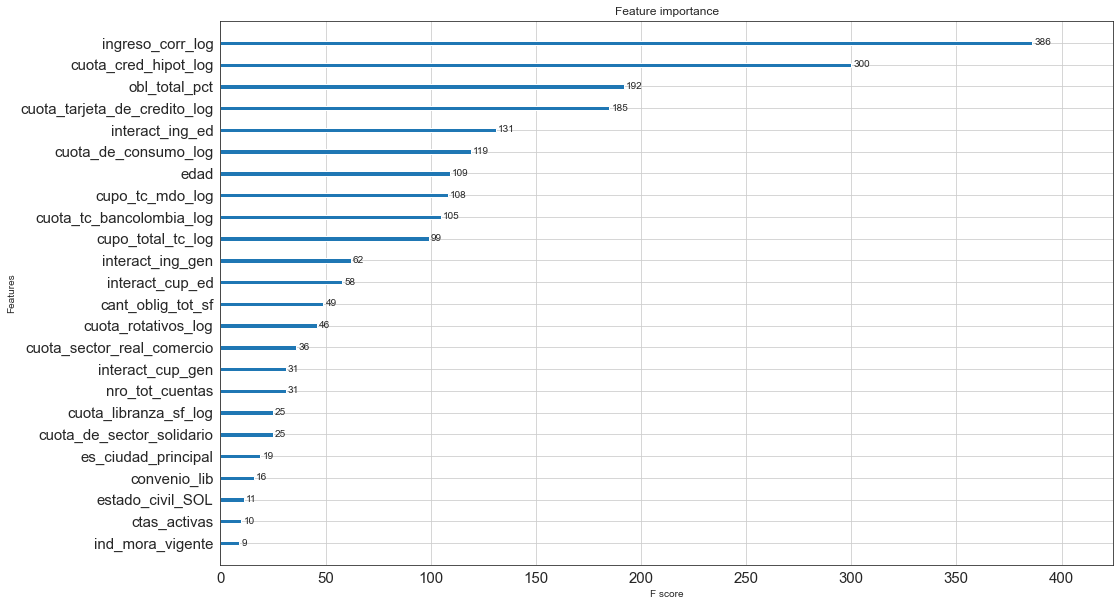

In [35]:
xgb.plot_importance(xgb_reg)

In [36]:
y_pred = xgb_reg.predict(X_test)
mean_absolute_percentage_error(y_pred, y_test)

0.8680735360341739

In [37]:
y_pred_train = xgb_reg.predict(X_train)
mean_absolute_percentage_error(y_pred_train, y_train)

0.4436128557160939

In [430]:
cat_reg = CatBoostRegressor()
cat_reg.fit(X_train, y_train, verbose=False)

In [431]:
catboost_predictions = cat_reg.predict(X_test)
mean_absolute_percentage_error(catboost_predictions, y_test)

0.7697726248607693

In [239]:
import optuna 
import joblib
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [253]:
def objective(trial: Trial,X,y) -> float:
    
    joblib.dump(study, 'study.pkl')
    
    train_X,test_X,train_y,test_y = train_test_split(X, y, test_size = 0.30,random_state = 101)

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 100),
                'max_depth':trial.suggest_int('max_depth', 2, 10),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
            }
    model = xgb.XGBRegressor(**param)

    model.fit(train_X,train_y)
    
    kfold = KFold(n_splits=5, random_state=101)
    results = cross_val_score(model, X, Y, cv=kfold, scoring=percentage_)
    predictions = model.predict(test_X)

    return mean_absolute_percentage_error(predictions,test_y)    

In [254]:
study = optuna.create_study(direction='minimize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,X,y),n_trials= 50)

[I 2021-01-19 19:16:23,393] A new study created in memory with name: no-name-b5c9bfc0-0312-43f6-a144-02247f475ce5
[I 2021-01-19 19:16:29,016] Trial 0 finished with value: 0.6416670454419807 and parameters: {'n_estimators': 57, 'max_depth': 7, 'reg_alpha': 0, 'reg_lambda': 2, 'min_child_weight': 1, 'gamma': 0, 'learning_rate': 0.1877371892229076, 'colsample_bytree': 0.47}. Best is trial 0 with value: 0.6416670454419807.
[I 2021-01-19 19:16:35,739] Trial 1 finished with value: 0.8654754205686288 and parameters: {'n_estimators': 82, 'max_depth': 7, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 4, 'gamma': 3, 'learning_rate': 0.014973192018657272, 'colsample_bytree': 0.22}. Best is trial 0 with value: 0.6416670454419807.
[I 2021-01-19 19:16:42,825] Trial 2 finished with value: 0.6835234600383058 and parameters: {'n_estimators': 69, 'max_depth': 8, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 0, 'gamma': 0, 'learning_rate': 0.03369000836421449, 'colsample_bytree': 0.290000000

[I 2021-01-19 19:18:04,796] Trial 25 finished with value: 0.6347102395977456 and parameters: {'n_estimators': 94, 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 4, 'gamma': 1, 'learning_rate': 0.05828899046817628, 'colsample_bytree': 0.65}. Best is trial 24 with value: 0.6333934836092139.
[I 2021-01-19 19:18:09,148] Trial 26 finished with value: 0.6868446952262435 and parameters: {'n_estimators': 78, 'max_depth': 3, 'reg_alpha': 4, 'reg_lambda': 0, 'min_child_weight': 4, 'gamma': 1, 'learning_rate': 0.028418676066706998, 'colsample_bytree': 0.72}. Best is trial 24 with value: 0.6333934836092139.
[I 2021-01-19 19:18:12,174] Trial 27 finished with value: 0.6349545631477521 and parameters: {'n_estimators': 86, 'max_depth': 2, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.08352897592966982, 'colsample_bytree': 0.61}. Best is trial 24 with value: 0.6333934836092139.
[I 2021-01-19 19:18:21,377] Trial 28 finished with value: 0.632

In [264]:
study.best_trial.params

{'n_estimators': 99,
 'max_depth': 8,
 'reg_alpha': 4,
 'reg_lambda': 1,
 'min_child_weight': 3,
 'gamma': 0,
 'learning_rate': 0.0601525142343335,
 'colsample_bytree': 0.71}

In [28]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.7713162150654792,
params {'n_estimators': 83, 'max_depth': 7, 'reg_alpha': 0, 'reg_lambda': 5, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.07552594062445633, 'colsample_bytree': 0.35}


In [159]:
best_params = {'n_estimators': 99,
 'max_depth': 8,
 'reg_alpha': 4,
 'reg_lambda': 1,
 'min_child_weight': 3,
 'gamma': 0,
 'learning_rate': 0.0601525142343335,
 'colsample_bytree': 0.71}
xgb_reg_log = xgb.XGBRegressor(**best_params)
xgb_reg_log.fit(X_train, np.log(y_train+1))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.71, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0601525142343335, max_delta_step=0, max_depth=8,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=99, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=4, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [160]:
y_pred = xgb_reg_log.predict(X_test)
mean_absolute_percentage_error(y_pred, np.log(y_test+1))

0.15774911579215442

In [161]:
best_params = {'n_estimators': 99,
 'max_depth': 8,
 'reg_alpha': 4,
 'reg_lambda': 1,
 'min_child_weight': 3,
 'gamma': 0,
 'learning_rate': 0.0601525142343335,
 'colsample_bytree': 0.71}
xgb_reg = xgb.XGBRegressor(**best_params)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.71, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0601525142343335, max_delta_step=0, max_depth=8,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=99, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=4, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [162]:
y_pred = xgb_reg.predict(X_test)
mean_absolute_percentage_error(y_pred, y_test)

0.6396620544524475

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='log_gasto_familiar'>

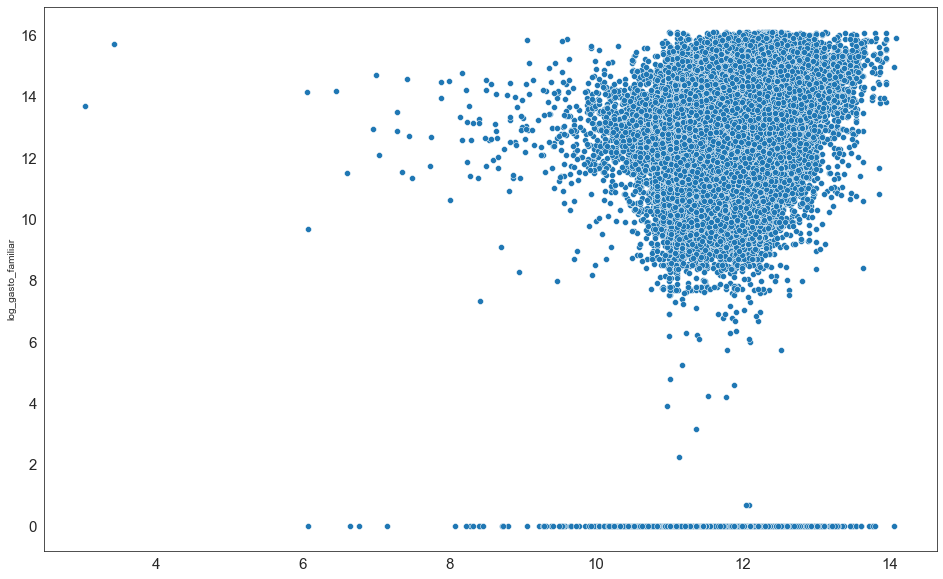

In [352]:
sns.scatterplot(y_pred, y_test)

In [75]:
from sklearn.neural_network import MLPRegressor

In [76]:
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

In [77]:
nn_predictions = regr.predict(X_test)
mean_absolute_percentage_error(nn_predictions, y_test)

3.7987137491026854

# GLM

In [87]:
fe_dataframe.modeling_dataframe[glm_features].isnull().sum()

ingreso_final                     0
ingreso_calculado                 0
cuota_cred_hipot_pct              0
cupo_total_tc                     0
cuota_tarjeta_de_credito_pct      0
cuota_de_consumo_pct              0
cuota_rotativos_pct               0
cuota_libranza_sf_pct             0
genero                            0
cuota_de_sector_solidario_pct     0
cuota_sector_real_comercio_pct    0
ind_mora_vigente                  0
ind_annio                         0
cuota_tc_bancolombia_pct          0
cupo_tc_mdo                       0
convenio_lib                      0
cant_oblig_tot_sf                 0
edad                              0
estado_civil_DIV                  0
estado_civil_NI                   0
estado_civil_OTRO                 0
estado_civil_SOL                  0
estado_civil_UL                   0
estado_civil_VIU                  0
ind                               0
nro_tot_cuentas                   0
ctas_activas                      0
ingreso_nomina              

In [39]:
# Fit Poisson regression of sat by weight\
glm_feat_formula = [
    'ingreso_corr_log',
    'cuota_cred_hipot_log',
    'cupo_total_tc_log',
    # 'cuota_tarjeta_de_credito_log',
    'cuota_de_consumo_log',
    'edad',
    # 'genero',
    'cuota_tc_bancolombia_log',
    'ind_annio',
    # 'cupo_tc_mdo_log',
   # 'edad:ingreso_corr',
   # 'edad*cuota_cred_hipot_log',
   #  'genero:ingreso_corr',
    'obl_total_pct',
    'ingreso_geo_alto',
    'ingreso_cero',
    'es_ciudad_principal'
]
glm_formula = 'np.log(gasto_familiar+1) ~ ' + ' + '.join(glm_feat_formula)
glm_features = feature_cols + ['gasto_familiar']
glm_data = fe_dataframe.modeling_dataframe[glm_features]
# glm_data = glm_data[glm_data['gasto_familiar'] < 10000000]
model = glm( glm_formula, data = glm_data,
            family = sm.families.Poisson()).fit()

# Display model results
print(model.summary())

                     Generalized Linear Model Regression Results                      
Dep. Variable:     np.log(gasto_familiar + 1)   No. Observations:               153356
Model:                                    GLM   Df Residuals:                   153344
Model Family:                         Poisson   Df Model:                           11
Link Function:                            log   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:            -4.5553e+05
Date:                        Tue, 19 Jan 2021   Deviance:                   2.7207e+05
Time:                                20:31:51   Pearson chi2:                 1.47e+05
No. Iterations:                             4                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

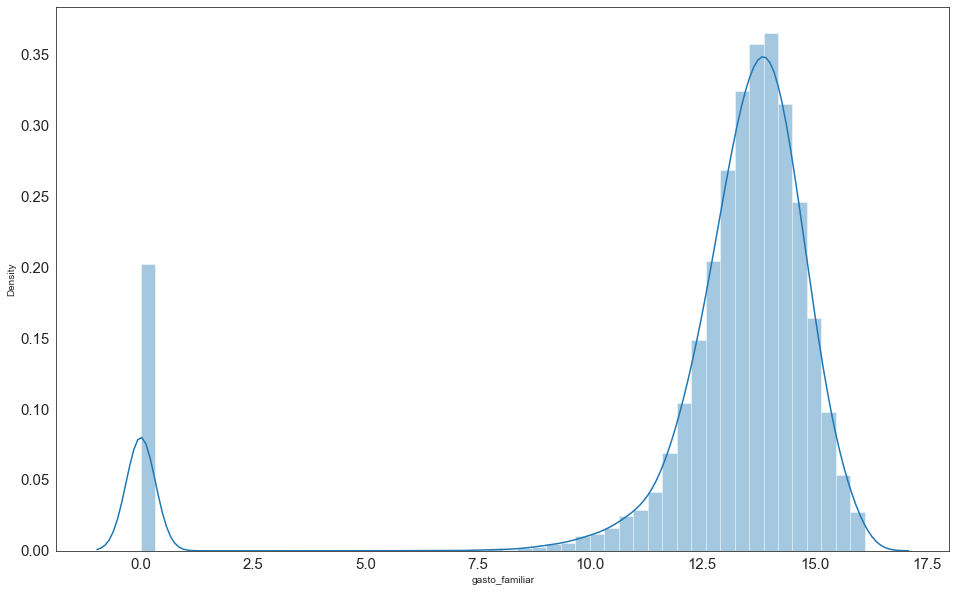

In [295]:
sns.distplot(np.log(glm_data['gasto_familiar']+1))

In [133]:
glm_data.describe(include='all')

,ingreso_final,ingreso_calculado,cuota_cred_hipot_pct,cupo_total_tc,cuota_tarjeta_de_credito_pct,cuota_de_consumo_pct,cuota_rotativos_pct,cuota_libranza_sf_pct,genero,cuota_de_sector_solidario_pct,...,ingreso_segurida_social,rep_calif_cred_B,rep_calif_cred_C,rep_calif_cred_D,rep_calif_cred_E,rep_calif_cred_F,rep_calif_cred_G,rep_calif_cred_H,rep_calif_cred_NApl,gasto_familiar
count,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,...,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000
mean,14.76997,2001145.57726,0.02100,6.00252,0.10404,0.19464,0.00570,0.02850,0.49557,0.01854,...,4.05077,0.13744,0.13861,0.11183,0.06993,0.04012,0.11104,0.09627,0.09490,765522.03685
std,1.56519,3777353.15946,0.14252,7.63325,0.47243,2.41957,0.30507,0.50487,0.49998,0.59299,...,6.53894,0.34431,0.34554,0.31516,0.25503,0.19624,0.31418,0.29496,0.29308,1058623.99122
min,0.00000,0.00000,-0.43312,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,14.26020,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,180354.00000
50%,14.79485,807503.00000,0.00000,0.00000,0.02056,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,426113.00000
75%,15.39770,2719204.50000,0.00000,15.29712,0.11120,0.14480,0.00000,0.00000,1.00000,0.00000,...,13.62691,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,910449.10500
max,21.18475,381096170.00000,62.76979,20.10337,137.49425,1017.77375,283.65719,117.11432,1.00000,301.53884,...,19.06253,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,9999293.00000


In [332]:
glm_predictions = model.predict(fe_dataframe.modeling_dataframe[glm_features])

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

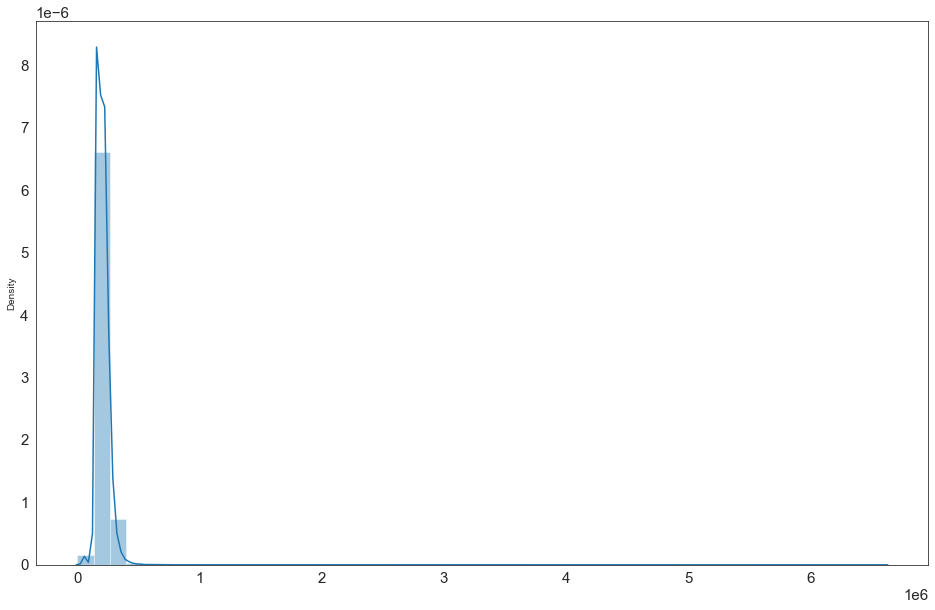

In [151]:
exp_prediction = np.exp(glm_predictions) - 1
sns.distplot(exp_prediction[exp_prediction < 10000000])

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future vers

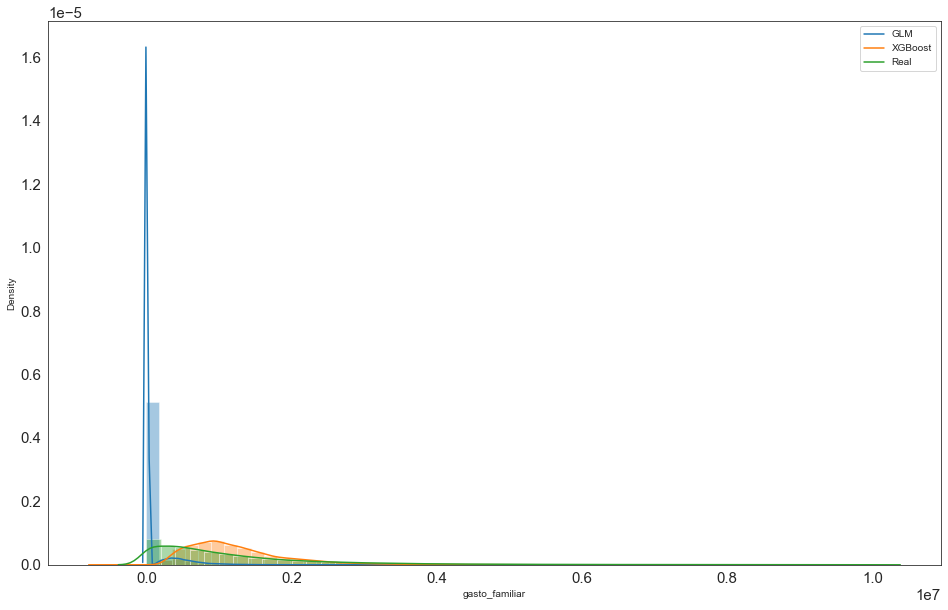

In [334]:
sns.distplot(final_predictions_glm[final_predictions_glm <  10000000])
sns.distplot(y_pred)
sns.distplot(fe_dataframe.modeling_dataframe['gasto_familiar'])
plt.legend(['GLM', "XGBoost", "Real"])

# DL model

In [150]:
nn_model = Sequential()
nn_model.add(Dense(30, activation = 'relu', input_shape = (X.shape[1],))) #Primera capa oculta, justo después de la capa input de 3 variables
nn_model.add(Dropout(0.2))
nn_model.add(Dense(30, activation = 'relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dense(30, activation = 'relu'))
nn_model.add(Dense(1))

nn_model.compile(optimizer = 'adam', loss = 'mse')
nn_model.fit(X_train, y_train, epochs=20)

Epoch 1/20
3355/3355 [==============================] - 5s 1ms/step - loss: 38.2824
Epoch 2/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.7941
Epoch 3/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.4961
Epoch 4/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.8006
Epoch 5/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.6510
Epoch 6/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.3454
Epoch 7/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5507
Epoch 8/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.4897
Epoch 9/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5531
Epoch 10/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5549
Epoch 11/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.3447
Epoch 12/20
3355/3355 [==============================] - 4s 1ms/step - los

In [87]:
nn_predictions = nn_model.predict(X_test)
mean_absolute_percentage_error(nn_predictions, y_test)

0.8384442947941376

# test

In [26]:
test_df = pd.read_csv("test_cleaned.csv").drop("Unnamed: 0", axis=1)
test_df

,id_registro,periodo,id_cli,edad,genero,estado_civil,ult_actual,ind_mora_vigente,departamento_residencia,mora_max,...,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,convenio_lib,ingreso_nomina,ingreso_segurida_social
0,4055#201902,201902,4055,46,M,CAS,20180807,N,ANTIOQUIA,NApl,...,282500.00000,19000.00000,127148000.00000,1797000.00000,7,2060457.20000,A,S,2734528.00000,0.00000
1,12598#201902,201902,12598,43,M,SOL,20180130,N,CUNDINAMARCA,Entre 0 y 30 dias,...,0.00000,0.00000,87661000.00000,0.00000,5,-71874365.80000,H,S,2291070.00000,0.00000
2,23697#201902,201902,23697,45,M,CAS,20190110,N,BOGOTA D.C.,Entre 0 y 30 dias,...,33000.00000,33000.00000,58967000.00000,0.00000,3,-1448765.30000,A,S,0.00000,0.00000
3,23768#201902,201902,23768,58,M,NI,20180208,N,BOGOTA D.C.,NApl,...,0.00000,0.00000,0.00000,0.00000,0,2208260.39000,G,S,0.00000,0.00000
4,7174#201902,201902,7174,52,F,DIV,20180825,N,BOGOTA D.C.,Entre 0 y 30 dias,...,4088500.00000,11000.00000,22746000.00000,0.00000,7,3212635.74000,A,S,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281661,8596193#202011,202011,8596193,47,F,SOL,20201010,N,ANTIOQUIA,Entre 0 y 30 dias,...,0.00000,0.00000,0.00000,0.00000,2,2101424.08500,A,S,2281362.50000,3876343.00000
281662,8616083#202011,202011,8616083,35,M,NI,20201003,N,BOGOTA D.C.,Entre 0 y 30 dias,...,8286666.66700,237000.00000,99000.00000,0.00000,12,11705497.77500,C,S,14510896.00000,0.00000
281663,8670207#202011,202011,8670207,47,M,DIV,20200616,N,CUNDINAMARCA,Entre 0 y 30 dias,...,30917000.00000,10350000.00000,300000.00000,0.00000,17,-41547904.85000,D,S,0.00000,0.00000
281664,8677655#202011,202011,8677655,42,F,CAS,20200423,N,ANTIOQUIA,Entre 0 y 30 dias,...,37608666.66700,1953000.00000,184811000.00000,0.00000,18,5313457.01250,B,S,11401109.00000,14481371.00000


In [59]:
final_prediction

0         661604.40069
1         985983.87458
2         897955.95914
3         347347.60933
4         682651.64371
              ...     
281661    454408.37963
281662   1171165.12779
281663   2991076.58477
281664   1017050.63458
281665    711716.64829
Length: 281666, dtype: float64

In [76]:
final_predictions_nn.reshape(-1,).shape

(281666,)

In [72]:
final_predictions_xgb.shape

(281666,)

In [88]:
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()
#final_prediction_cat = cat_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])

In [183]:
final_predictions_xgb_log=np.exp(xgb_reg_log.predict(test_df_modeling.modeling_dataframe[feature_cols]))-1
final_predictions_xgb=xgb_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])
final_predictions_glm=np.exp(model.predict(test_df_modeling.modeling_dataframe[feature_cols]))-1
final_predictions_nn=nn_model.predict(test_df_modeling.modeling_dataframe[feature_cols])                  
final_prediction = final_predictions_glm*0.25 + final_predictions_xgb*0.25 + \
                   final_predictions_nn.reshape(-1,)*0.25 + final_predictions_xgb_log*0.25

In [139]:
xgb_train=xgb_reg.predict(X_test)
nn_train=nn_model.predict(X_test)
glm_train = np.exp(model.predict(X_test))-1
ensemble_score= xgb_train*0.5 + glm_train*0.0 + nn_train.reshape(-1,)*0.5
mean_absolute_percentage_error(ensemble_score, y_test)

0.9999746524016796

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

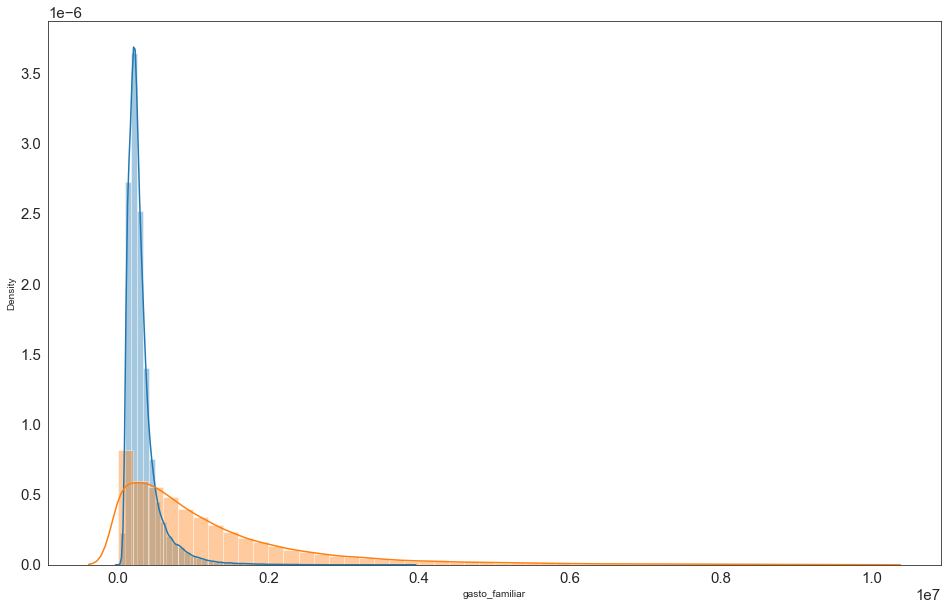

In [184]:
sns.distplot(final_prediction[final_prediction < 10000000])
#sns.distplot(final_predictions_nn[final_predictions_nn < 10000000])
sns.distplot(fe_dataframe.modeling_dataframe['gasto_familiar'])
#sns.distplot(y_test)

In [185]:
submission = pd.concat([test_df['id_registro'],pd.Series(final_prediction)], axis=1)
submission.columns = ["id_registro", "gasto_familiar"]
submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
submission

,id_registro,gasto_familiar
0,4055#201902,254486.45140
1,12598#201902,269680.37080
2,23697#201902,323651.26380
3,23768#201902,216778.38190
4,7174#201902,369292.42640
...,...,...
281661,8596193#202011,301050.72020
281662,8616083#202011,640165.57000
281663,8670207#202011,1589629.13130
281664,8677655#202011,502436.08200


In [92]:
class PrepareSubmission:
    
    def __init__(self, dataframe, model):
        self.test_dataframe = dataframe
        self.model = model
     
    def makePrediction(self, dataframe)
        test_df_modeling = DataFramePreProcessor(test_df, test=True)
        test_df_modeling.process()
        final_predictions=xgb_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])
    
    
    def prepareSubmissionDF(self, dataframe):
        submission = pd.concat([test_df['id_registro'],pd.Series(final_predictions)], axis=1)
        submission.columns = ["id_registro", "gasto_familiar"]
    
    
    def submit(self):
        submission.to_csv("submission_underground.csv", index=False)

In [186]:
submission.to_csv("submission_underground.csv", index=False)

In [349]:
final_prediction[final_prediction < 0]

32        -49577.95957
37        -31132.87461
62        -53999.65246
87        -84479.18775
107       -13693.60451
              ...     
281250   -157127.52459
281302     -9315.22841
281462    -12892.82637
281547    -16814.90453
281553    -13733.63068
Length: 8545, dtype: float64

# Compare predictions


In [92]:
best_submission = pd.read_csv("submission_underground XGBOOST + GLM.csv")
best_submission

,id_registro,gasto_familiar
0,4055#201902,571420.17471
1,12598#201902,349476.25758
2,23697#201902,540001.77972
3,23768#201902,409353.73447
4,7174#201902,611864.98709
...,...,...
281661,8596193#202011,502656.56050
281662,8616083#202011,1159578.39967
281663,8670207#202011,3470185.48417
281664,8677655#202011,1136492.28569


g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

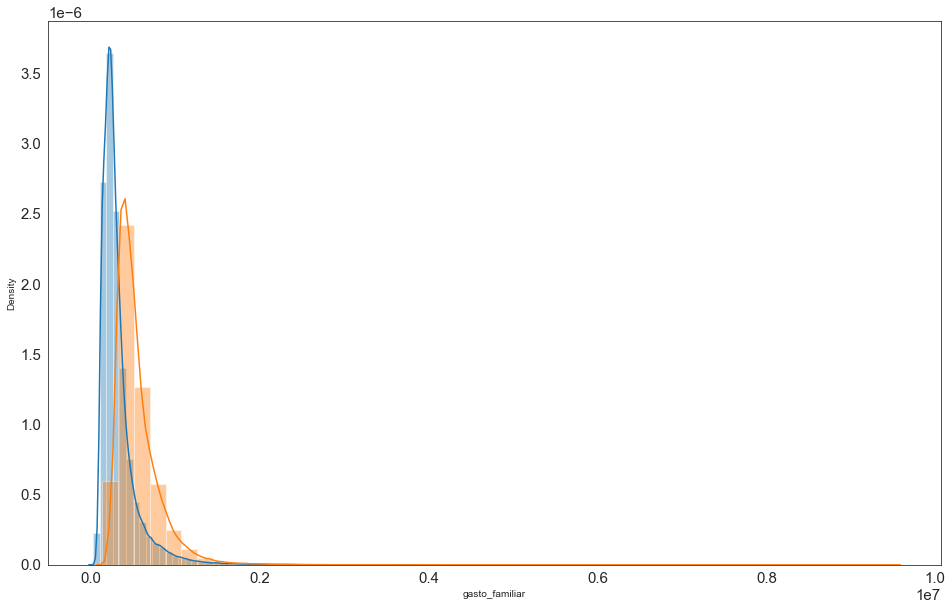

In [187]:
sns.distplot(submission['gasto_familiar'])
sns.distplot(best_submission[best_submission['gasto_familiar'] < 10000000]['gasto_familiar'])

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

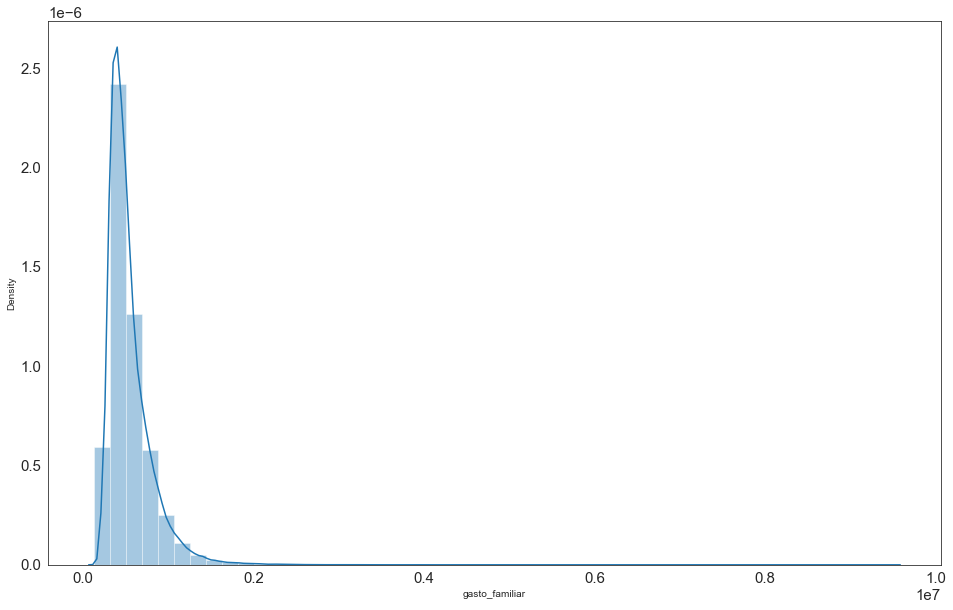

In [107]:
sns.distplot(best_submission[best_submission['gasto_familiar'] < 10000000]['gasto_familiar'])


In [129]:
np.quantile(submission['gasto_familiar'], 0.999999)

10000000.0